<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/%EC%84%9C%EC%9A%B8%ED%98%95%20%EB%AC%BC%EB%A5%98%EC%84%A4%EB%B9%84(p-median%2Bvrp%EC%84%A4%EA%B3%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install ortools


In [10]:
# ============================================
# 물류센터 입지 선정 + 배송 경로 계획 (무료 툴만 사용)
# - 시설입지: PuLP (기본 CBC 솔버)
# - VRP: OR-Tools
# --------------------------------------------
# 필요 패키지: pandas, numpy, pulp, ortools
# CSV 파일: DistributionCenter.csv, Customer.csv, Truck.csv
#   → 아래 INPUT_DIR 경로에 넣어두고 실행
# ============================================

import pandas as pd
import numpy as np
from math import sqrt, ceil

import pulp as pl
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ===== 0. 데이터 경로 설정 =====
# zip 풀어서 나온 csv가 들어있는 폴더 이름으로 바꿔줘
INPUT_DIR = "./"   # 같은 폴더면 "./" 그대로 쓰면 됨

dc_path    = INPUT_DIR + "DistributionCenter.csv"
cust_path  = INPUT_DIR + "Customer.csv"
truck_path = INPUT_DIR + "Truck.csv"

# ===== 1. 데이터 불러오기 =====
dc    = pd.read_csv(dc_path)    # 물류센터 정보
cust  = pd.read_csv(cust_path)  # 고객 정보
truck = pd.read_csv(truck_path) # 트럭 정보

print("=== DistributionCenter.csv ===")
print(dc.head(), "\n")
print("=== Customer.csv ===")
print(cust.head(), "\n")
print("=== Truck.csv ===")
print(truck, "\n")

# 인덱스 설정
I = range(len(cust))  # 고객 index
J = range(len(dc))    # 센터 index

# 파라미터 추출
demand     = cust["DEMAND"].values
capacity   = dc["CAPACITY"].values
fixed_cost = dc["COST"].values

# 거리 행렬 (유클리드 거리)
dist = [
    [
        sqrt((cust.loc[i, "X"] - dc.loc[j, "X"])**2 +
             (cust.loc[i, "Y"] - dc.loc[j, "Y"])**2)
        for j in J
    ]
    for i in I
]

transport_unit_cost = 1.0  # 거리 1당 비용 (필요하면 바꿀 수 있음)

# ===== 2. 시설입지 최적화 (Facility Location, PuLP) =====
print("\n===== 1단계: 시설입지 최적화 시작 =====")

model = pl.LpProblem("FacilityLocation", pl.LpMinimize)

# 의사결정변수
x = pl.LpVariable.dicts("assign", (I, J), 0, 1, cat="Binary")  # 고객 i -> 센터 j
y = pl.LpVariable.dicts("open", J, 0, 1, cat="Binary")         # 센터 개설 여부

# 목적함수: 고정비 + 운송비
fixed_term = pl.lpSum(fixed_cost[j] * y[j] for j in J)
transport_term = pl.lpSum(
    transport_unit_cost * dist[i][j] * demand[i] * x[i][j]
    for i in I for j in J
)
model += fixed_term + transport_term

# 제약1: 각 고객은 정확히 1개의 센터에 할당
for i in I:
    model += pl.lpSum(x[i][j] for j in J) == 1

# 제약2: 센터 용량 제약
for j in J:
    model += pl.lpSum(demand[i] * x[i][j] for i in I) <= capacity[j] * y[j]

# 풀기 (무료 CBC 솔버)
solver = pl.PULP_CBC_CMD(msg=True)
model.solve(solver)

print("Status:", pl.LpStatus[model.status])
print("Total cost (facility + transport):", pl.value(model.objective))

# 어떤 센터를 여는지
open_centers = [j for j in J if pl.value(y[j]) > 0.5]
print("열린 물류센터 index:", open_centers)

# 고객별로 어떤 센터에 배정됐는지
assign_center = {}
for i in I:
    for j in J:
        if pl.value(x[i][j]) > 0.5:
            assign_center[i] = j
            break

cust_assign = cust.copy()
cust_assign["center_idx"] = cust_assign.index.map(assign_center.get)

print("\n=== 고객별 배정 결과 (상위 10개) ===")
print(cust_assign.head(10))

# ===== 3. VRP용 함수 정의 (OR-Tools) =====

def build_vrp_data(customers_df, depot_xy, vehicle_capacity):
    """
    한 물류센터에 배정된 고객들에 대해
    OR-Tools VRP에 넣을 데이터 구조 생성
    """
    # depot + 고객 좌표
    points = [(depot_xy[0], depot_xy[1])] + list(
        zip(customers_df["X"], customers_df["Y"])
    )
    # depot 수요 = 0
    demands = [0] + list(customers_df["DEMAND"])

    n = len(points)
    dist_matrix = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            dx = points[i][0] - points[j][0]
            dy = points[i][1] - points[j][1]
            # OR-Tools는 int 사용 → 반올림
            dist_matrix[i][j] = int(round(sqrt(dx*dx + dy*dy)))

    total_demand = sum(demands)
    num_vehicles = max(1, ceil(total_demand / vehicle_capacity))

    data = {
        "distance_matrix": dist_matrix,
        "demands": demands,
        "vehicle_capacities": [vehicle_capacity] * num_vehicles,
        "num_vehicles": num_vehicles,
        "depot": 0,
    }
    return data


def solve_vrp(data):
    """
    OR-Tools로 용량제약 VRP 풀기
    """
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]),
        data["num_vehicles"],
        data["depot"],
    )
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    # 수요(용량) 콜백
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,  # slack
        data["vehicle_capacities"],
        True,
        "Capacity",
    )

    # 탐색 옵션 설정
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(10)  # 10초 제한

    solution = routing.SolveWithParameters(search_params)

    routes = []
    if solution:
        for vehicle_id in range(data["num_vehicles"]):
            index = routing.Start(vehicle_id)
            # 이 차량이 아무 곳도 안 가면 skip
            if routing.IsEnd(solution.Value(routing.NextVar(index))):
                continue

            route_nodes = []
            route_load = 0
            route_dist = 0

            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                route_nodes.append(node)
                route_load += data["demands"][node]
                prev_index = index
                index = solution.Value(routing.NextVar(index))
                route_dist += routing.GetArcCostForVehicle(prev_index, index, vehicle_id)

            routes.append(
                {
                    "vehicle": vehicle_id,
                    "nodes": route_nodes,  # 0 = depot, 1~ = 고객
                    "load": route_load,
                    "distance": route_dist,
                }
            )
    return routes

# ===== 4. 각 센터별 VRP 실행 =====
print("\n===== 2단계: 각 물류센터별 VRP 최적 경로 계산 =====")

# 트럭 적재용량 (여러 줄이면 첫 줄 기준으로 사용)
truck_capacity = int(truck.loc[0, "CAPACITY"])

all_center_routes = {}

for j in open_centers:
    # 센터 j에 배정된 고객들만 추출
    assigned_customers = cust_assign[cust_assign["center_idx"] == j].copy()
    if assigned_customers.empty:
        continue

    # index를 고정 리스트로 저장 (나중에 노드→고객번호 매핑에 사용)
    assigned_customers = assigned_customers.reset_index(drop=False)
    # reset_index로 생긴 원래 고객 index 컬럼 이름 확인
    # (기본은 "index")
    if "index" in assigned_customers.columns:
        original_idx_col = "index"
    else:
        # 혹시 다르면 여기서 바꿔줘도 됨
        original_idx_col = assigned_customers.columns[0]

    depot_xy = (dc.loc[j, "X"], dc.loc[j, "Y"])
    data = build_vrp_data(assigned_customers, depot_xy, truck_capacity)
    routes = solve_vrp(data)

    all_center_routes[j] = {
        "depot_xy": depot_xy,
        "customers": assigned_customers,
        "routes": routes,
        "original_idx_col": original_idx_col,
    }

# ===== 5. 결과 출력 =====
for j, info in all_center_routes.items():
    print(f"\n==============================")
    print(f"물류센터 {j} (좌표 {info['depot_xy']})")
    print("==============================")

    customers_df = info["customers"]
    idx_col = info["original_idx_col"]

    for r in info["routes"]:
        # OR-Tools 노드번호(1~) → 원래 고객 index로 변환
        customer_idx_seq = []
        for node in r["nodes"]:
            if node == 0:
                continue  # depot
            # node 1 → customers_df의 0번째 행
            row = customers_df.iloc[node - 1]
            customer_idx_seq.append(int(row[idx_col]))

        print(
            f"차량 {r['vehicle']}: depot -> 고객 {customer_idx_seq} -> depot "
            f"| 적재량={r['load']} | 총거리={r['distance']}"
        )

print("\n=== 모든 계산 완료! ===")


=== DistributionCenter.csv ===
    X   Y  CAPACITY  COST
0  30  46     10000    40
1  37  39     10000    40
2  23  43     10000    40
3  56  38     10000    40
4  42  43     10000    40 

=== Customer.csv ===
    X   Y  DEMAND
0  37  52       7
1   9  49      30
2   2  64      16
3   0  26       9
4   0  30      21 

=== Truck.csv ===
   CAPACITY
0       160 


===== 1단계: 시설입지 최적화 시작 =====
Status: Optimal
Total cost (facility + transport): 14161.700539085214
열린 물류센터 index: [0, 1, 2, 3, 4]

=== 고객별 배정 결과 (상위 10개) ===
    X   Y  DEMAND  center_idx
0  37  52       7           0
1   9  49      30           2
2   2  64      16           2
3   0  26       9           2
4   0  30      21           2
5   1  47      15           2
6   7  63      19           2
7   1  62      23           2
8   2  33      11           2
9  51  21       5           3

===== 2단계: 각 물류센터별 VRP 최적 경로 계산 =====

물류센터 0 (좌표 (np.int64(30), np.int64(46)))
차량 0: depot -> 고객 [26, 47, 25, 30, 0] -> depot | 적재량=57 | 총거리=60



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49468 (\N{HANGUL SYLLABLE SEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

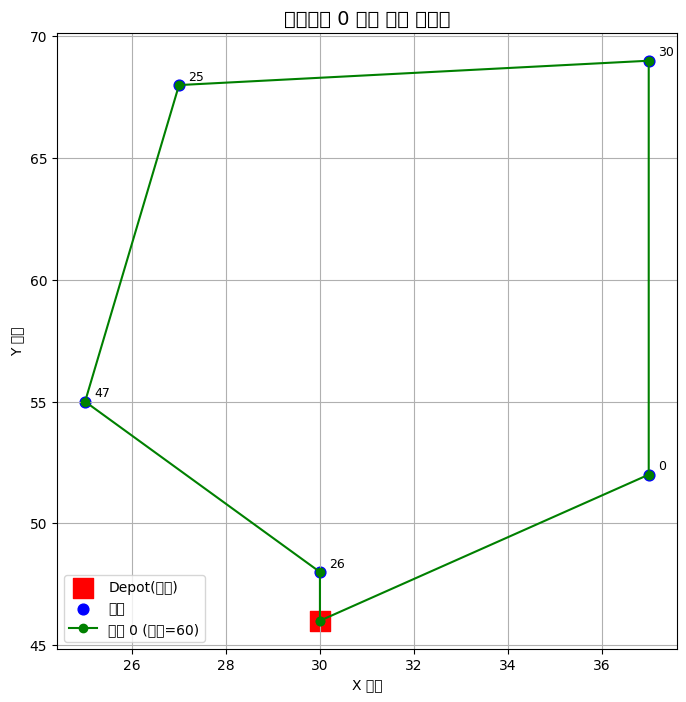

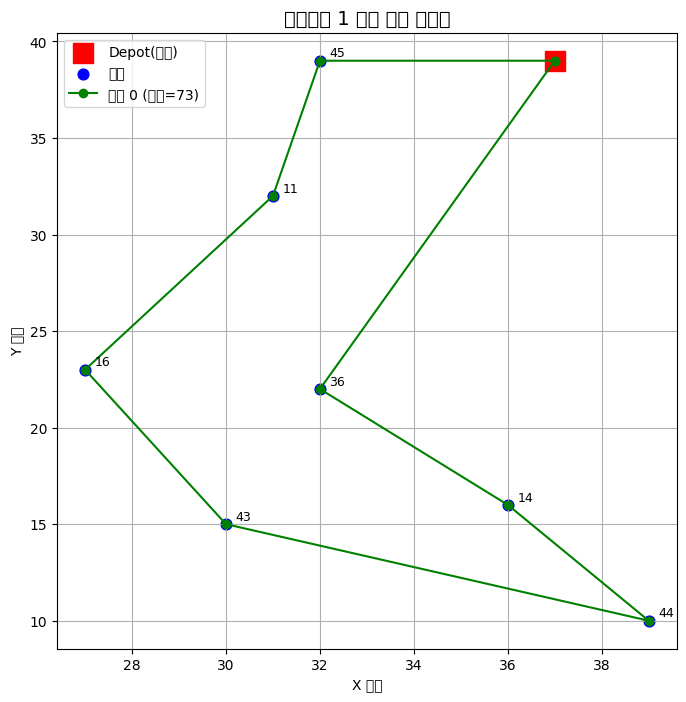

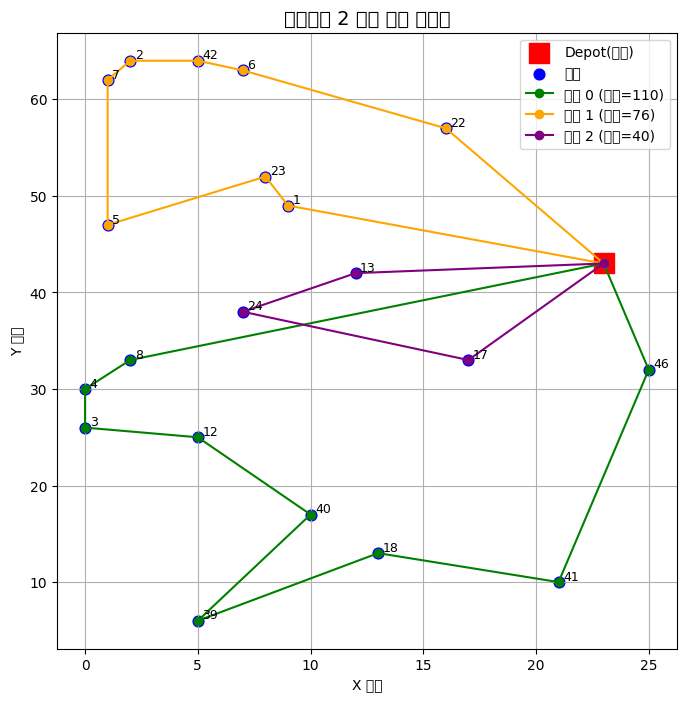

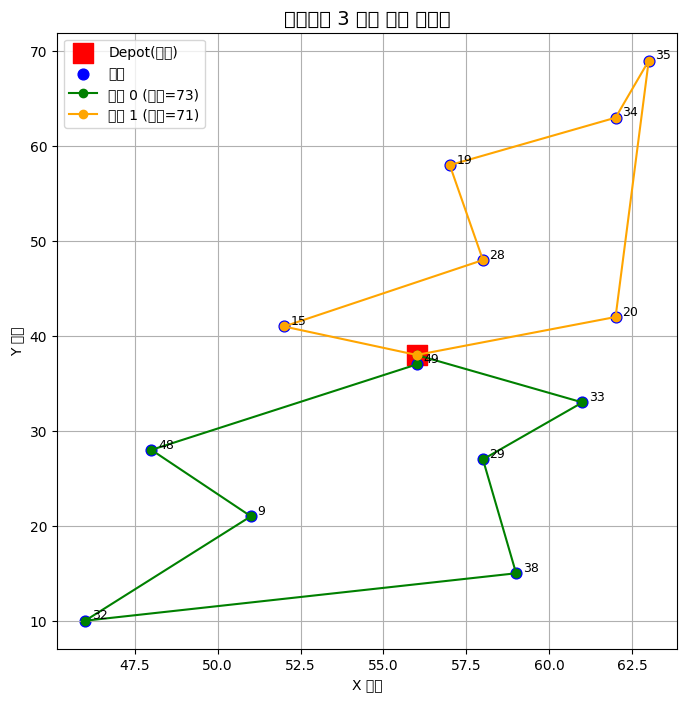

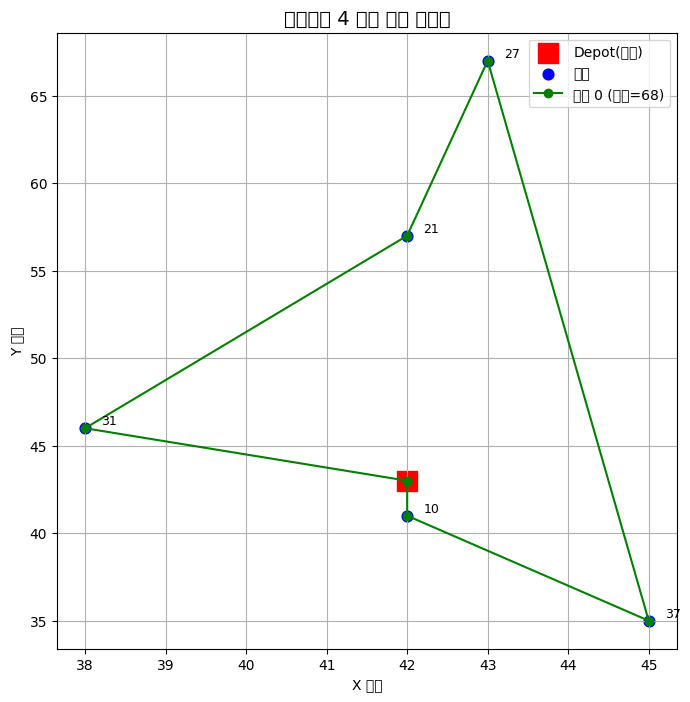

In [12]:
# ============================================
# 5. VRP 결과 시각화 (matplotlib)
# ============================================
import matplotlib.pyplot as plt

def plot_vrp(center_id, info):
    """
    한 물류센터(center_id)에 대해 VRP 경로를 시각화해주는 함수
    info = all_center_routes[center_id]
    """

    depot_x, depot_y = info["depot_xy"]
    customers_df = info["customers"]
    idx_col = info["original_idx_col"]

    plt.figure(figsize=(8, 8))
    plt.title(f"물류센터 {center_id} 배송 경로 시각화", fontsize=14)

    # === Depot 그리기 ===
    plt.scatter(depot_x, depot_y, c="red", s=200, marker="s", label="Depot(센터)")

    # === 고객들 그리기 ===
    plt.scatter(customers_df["X"], customers_df["Y"], c="blue", s=60, label="고객")

    # 고객 번호 표시
    for _, row in customers_df.iterrows():
        plt.text(row["X"] + 0.2, row["Y"] + 0.2, str(int(row[idx_col])), fontsize=9)

    # === 차량 경로 그리기 ===
    colors = ["green", "orange", "purple", "brown", "pink", "gray"]

    for r in info["routes"]:
        route_nodes = r["nodes"]
        path_x = []
        path_y = []

        for node in route_nodes:
            if node == 0:
                # depot
                x, y = depot_x, depot_y
            else:
                row = customers_df.iloc[node - 1]
                x, y = row["X"], row["Y"]
            path_x.append(x)
            path_y.append(y)

        # 마지막에 depot으로 돌아가는 궤적 닫아주기
        path_x.append(depot_x)
        path_y.append(depot_y)

        plt.plot(path_x, path_y, "-o", color=colors[r["vehicle"] % len(colors)],
                 label=f"차량 {r['vehicle']} (거리={r['distance']})")

    plt.xlabel("X 좌표")
    plt.ylabel("Y 좌표")
    plt.legend()
    plt.grid(True)
    plt.show()


# ============================================
# 모든 물류센터에 대해 시각화 실행
# ============================================
for center_id, info in all_center_routes.items():
    plot_vrp(center_id, info)


In [13]:
# ============================================
# 총비용 & 트럭 대수 계산 코드
# ============================================

print("\n===== 총비용 + 트럭 대수 계산 =====")

# 1) 시설 고정비
facility_open_cost = sum(
    dc.loc[j, "COST"] for j in open_centers
)
print(f"시설 고정비: {facility_open_cost}")

# 2) 고객 할당 기반 운송비
#   (수요 × 거리 × 단가) 의 합
transport_unit_cost = 1.0  # 혹시 코드에서 바꿨다면 동일하게!
total_transport_cost = 0

for i in range(len(cust)):
    j = cust_assign.loc[i, "center_idx"]           # 고객 i가 배정된 센터 j
    dist_ij = sqrt((cust.loc[i, "X"] - dc.loc[j, "X"])**2 +
                   (cust.loc[i, "Y"] - dc.loc[j, "Y"])**2)
    total_transport_cost += dist_ij * cust.loc[i, "DEMAND"] * transport_unit_cost

print(f"운송비 총합: {total_transport_cost}")

# 3) 총비용 = 시설 고정비 + 운송비
total_cost = facility_open_cost + total_transport_cost
print(f"\n👉 총비용 = {total_cost}")

# ============================================
# 트럭 관련 계산
# ============================================

total_trucks = 0
total_distance = 0

for j, info in all_center_routes.items():
    routes = info["routes"]
    num_trucks = len(routes)
    total_trucks += num_trucks

    center_distance = sum(r["distance"] for r in routes)
    total_distance += center_distance

    print(f"\n[물류센터 {j}]")
    print(f"- 사용된 트럭 수: {num_trucks}대")
    print(f"- 센터 총 운행거리: {center_distance}")

print("\n===== 전체 네트워크 결과 =====")
print(f"총 트럭 수: {total_trucks}대")
print(f"총 운행거리: {total_distance}")
print(f"고객당 평균 운행거리: {total_distance / len(cust):.2f}")



===== 총비용 + 트럭 대수 계산 =====
시설 고정비: 200
운송비 총합: 13961.700539085214

👉 총비용 = 14161.700539085214

[물류센터 0]
- 사용된 트럭 수: 1대
- 센터 총 운행거리: 60

[물류센터 1]
- 사용된 트럭 수: 1대
- 센터 총 운행거리: 73

[물류센터 2]
- 사용된 트럭 수: 3대
- 센터 총 운행거리: 226

[물류센터 3]
- 사용된 트럭 수: 2대
- 센터 총 운행거리: 144

[물류센터 4]
- 사용된 트럭 수: 1대
- 센터 총 운행거리: 68

===== 전체 네트워크 결과 =====
총 트럭 수: 8대
총 운행거리: 571
고객당 평균 운행거리: 11.42


In [14]:
# ============================================
# 총비용 계산 코드 (시설 고정비 + 운송비)
# ============================================

from math import sqrt

print("\n===== 총비용 계산 =====")

# 1) 시설 고정비 (열린 센터들의 COST 합)
facility_open_cost = sum(dc.loc[j, "COST"] for j in open_centers)
print(f"시설 고정비: {facility_open_cost}")

# 2) 운송비 계산 (거리 × 수요 × 단가)
transport_unit_cost = 1.0  # 앞에서 설정한 단가와 동일하게 유지!

total_transport_cost = 0

for i in range(len(cust)):
    j = cust_assign.loc[i, "center_idx"]   # 고객 i가 배정된 센터

    # 고객–센터 거리 계산
    dist_ij = sqrt(
        (cust.loc[i, "X"] - dc.loc[j, "X"])**2 +
        (cust.loc[i, "Y"] - dc.loc[j, "Y"])**2
    )

    # 운송비 누적
    total_transport_cost += dist_ij * cust.loc[i, "DEMAND"] * transport_unit_cost

print(f"운송비 총합: {total_transport_cost}")

# 3) 총비용 = 시설비 + 운송비
total_cost = facility_open_cost + total_transport_cost

print(f"\n👉 총비용 = {total_cost}")
print("============================================")



===== 총비용 계산 =====
시설 고정비: 200
운송비 총합: 13961.700539085214

👉 총비용 = 14161.700539085214


In [15]:
pip install pyscipopt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 58.0 MB/s eta 0:00:00


In [27]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2



고객 수: 50 / 물류센터 후보지 수: 5 / 트럭 적재용량: 160

[입지선정 결과 - DistributionCenter 기반]
선정된 DC 인덱스 (DistributionCenter.csv 기준): [2, 3]
p-median 최소비용(참고용): 1020.8514091638983

[DC별 고객 배정 결과]
DC 2 → 고객 수 33명
DC 3 → 고객 수 17명

[DC별 VRP 결과]

=== DC 2 기준 VRP ===
DC 총 비용: 323
경로 수: 4

=== DC 3 기준 VRP ===
DC 총 비용: 170
경로 수: 2

전체 DC + VRP 총 비용: 493


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

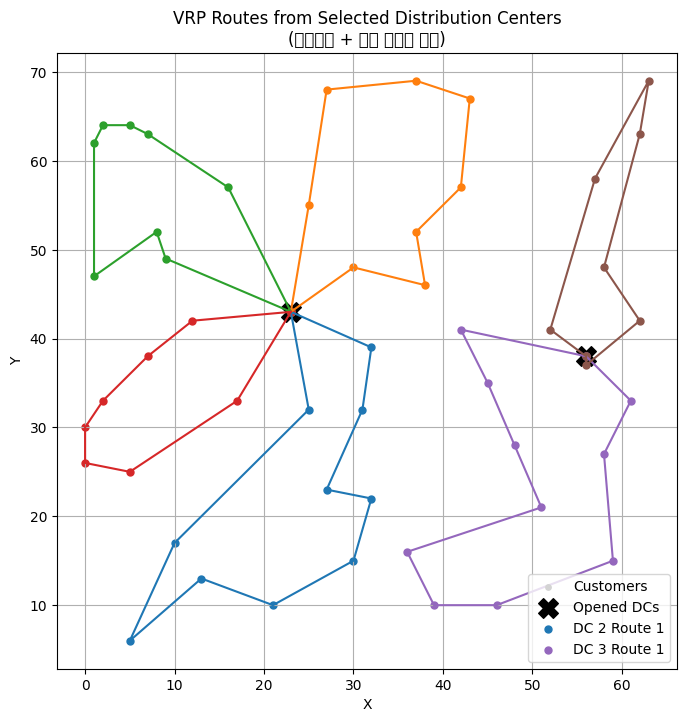

In [37]:
# ============================================================
# 0. 라이브러리 임포트
# ============================================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from itertools import combinations
from math import sqrt, ceil
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt

# ============================================================
# 1. 데이터 불러오기
# ============================================================
cust = pd.read_csv("Customer.csv")
truck_df = pd.read_csv("Truck.csv")
dc = pd.read_csv("DistributionCenter.csv")

cust_xy = cust[["X", "Y"]].values              # 고객 좌표 (N x 2)
dc_xy = dc[["X", "Y"]].values                  # 물류센터 후보 좌표 (M x 2)
demands = cust["DEMAND"].astype(int).values    # 고객 수요
truck_capacity = int(truck_df.loc[0, "CAPACITY"])

N = len(cust_xy)
M = len(dc_xy)
print("고객 수:", N, "/ 물류센터 후보지 수:", M, "/ 트럭 적재용량:", truck_capacity)

# ============================================================
# 2. 서울형 혼잡 패널티 함수 (좌표 범위는 예시이므로 필요하면 조정)
# ============================================================
def get_penalty(x, y):
    # 최상 혼잡: 도심(종로/중구/강남역) 예시
    if 450 <= x <= 520 and 800 <= y <= 860:
        return 1.8
    if 200 <= x <= 260 and 400 <= y <= 460:
        return 1.8
    # 중간 혼잡: 서부간선도로 예시
    if 100 <= x <= 200 and 300 <= y <= 450:
        return 1.3
    # 준혼잡: 홍대/성수 등 상권 예시
    if 300 <= x <= 380 and 650 <= y <= 720:
        return 1.2
    # 기본
    return 1.0

# 고객 ↔ DC 거리행렬 + 고객 위치 기준 패널티 적용 (N x M)
base_dist_cust_dc = cdist(cust_xy, dc_xy, metric="euclidean")
penalty_cust = np.array([get_penalty(x, y) for x, y in cust_xy])  # N
dist_pen_cust_dc = base_dist_cust_dc * penalty_cust[:, None]

# ============================================================
# 3. p-Median : DC 후보지 중 p개 선택
#    (고객 ↔ DC 비용을 최소화하는 후보 조합 찾기)
# ============================================================
def p_median_dc(p):
    best_cost = 1e18
    best_combo = None

    for combo in combinations(range(M), p):  # DC 후보지 index 조합
        combo = list(combo)
        # 각 고객이 combo 중 가장 가까운 DC에 간다고 가정
        cost = np.min(dist_pen_cust_dc[:, combo], axis=1).sum()
        if cost < best_cost:
            best_cost = cost
            best_combo = combo

    return best_combo, best_cost

p = 2   # 설치할 물류센터 개수 (원하면 1~5 중 바꿔보기)
open_dcs, pm_cost = p_median_dc(p)

print("\n[입지선정 결과 - DistributionCenter 기반]")
print("선정된 DC 인덱스 (DistributionCenter.csv 기준):", open_dcs)
print("p-median 최소비용(참고용):", pm_cost)

# ============================================================
# 4. 고객 → 선택된 DC로 배정
# ============================================================
assignments = [[] for _ in range(p)]  # DC별 고객 리스트

for i in range(N):
    dists = [dist_pen_cust_dc[i, j] for j in open_dcs]
    nearest = int(np.argmin(dists))
    assignments[nearest].append(i)

print("\n[DC별 고객 배정 결과]")
for idx, group in enumerate(assignments):
    print(f"DC {open_dcs[idx]} → 고객 수 {len(group)}명")

# ============================================================
# 5. 각 DC 기준 VRP (센터 좌표 = DistributionCenter.csv)
# ============================================================
def solve_vrp_for_dc(dc_index, cust_indices, truck_capacity):

    # 0번 노드 = depot(해당 DC 위치)
    depot_coord = dc_xy[dc_index]
    cust_coords = cust_xy[cust_indices]

    local_coords = np.vstack([depot_coord, cust_coords])
    local_demands = np.array([0] + list(demands[cust_indices]), dtype=int)

    num_nodes = int(local_coords.shape[0])

    # 거리 + 패널티 계산
    def calc_dist(i, j):
        x1, y1 = local_coords[i]
        x2, y2 = local_coords[j]
        base = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        penalty = get_penalty(x1, y1)  # 출발지 기준 패널티
        return int(base * penalty)

    dist_matrix = [[calc_dist(i, j) for j in range(num_nodes)]
                   for i in range(num_nodes)]

    total_demand = int(local_demands.sum())
    cap = int(truck_capacity)
    num_vehicles = max(1, int(ceil(total_demand / cap)))

    manager = pywrapcp.RoutingIndexManager(num_nodes, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백
    def transit_callback(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return dist_matrix[i][j]

    transit_idx = routing.RegisterTransitCallback(transit_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # 수요 콜백
    def demand_callback(from_index):
        node = manager.IndexToNode(from_index)
        return int(local_demands[node])

    demand_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_idx,
        0,
        [cap] * num_vehicles,
        True,
        "Capacity",
    )

    # 탐색 세팅
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(5)

    solution = routing.SolveWithParameters(search_params)

    routes_coords = []   # 각 route를 좌표 배열로 저장
    total_cost = 0

    if solution:
        for v in range(num_vehicles):
            index = routing.Start(v)

            # 이 차량이 아무 고객도 안 가면 스킵
            if routing.IsEnd(solution.Value(routing.NextVar(index))):
                continue

            node_list = []
            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                node_list.append(node)
                prev = index
                index = solution.Value(routing.NextVar(index))
                total_cost += routing.GetArcCostForVehicle(prev, index, v)

            # depot으로 복귀 (0번 노드 추가)
            node_list.append(0)
            # 좌표 시퀀스로 변환해서 저장
            routes_coords.append(local_coords[node_list])

    return routes_coords, total_cost


# ============================================================
# 6. DC별 VRP 실행
# ============================================================
all_routes_coords = []   # [(dc_index, [route1_coords, route2_coords,...]), ...]
all_costs = 0

print("\n[DC별 VRP 결과]")

for k, dc_idx in enumerate(open_dcs):
    print(f"\n=== DC {dc_idx} 기준 VRP ===")
    routes_coords, cost = solve_vrp_for_dc(dc_idx, assignments[k], truck_capacity)
    all_routes_coords.append((dc_idx, routes_coords))
    all_costs += cost

    print("DC 총 비용:", cost)
    print("경로 수:", len(routes_coords))

print("\n====================================")
print("전체 DC + VRP 총 비용:", all_costs)
print("====================================")

# ============================================================
# 7. 그래프 시각화 (고객 + DC + 경로)
# ============================================================
plt.figure(figsize=(8,8))

# 모든 고객
plt.scatter(cust_xy[:,0], cust_xy[:,1],
            s=15, color='lightgray', label='Customers')

# 선택된 DC (검은색 X)
open_dc_coords = dc_xy[open_dcs]
plt.scatter(open_dc_coords[:,0], open_dc_coords[:,1],
            marker='X', s=200, color='black', label='Opened DCs')

route_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
                'tab:brown','tab:pink','tab:cyan','tab:olive']

color_idx = 0
for dc_idx, routes_coords in all_routes_coords:
    for r_i, rc in enumerate(routes_coords):
        col = route_colors[color_idx % len(route_colors)]
        color_idx += 1
        plt.plot(rc[:,0], rc[:,1], '-', linewidth=1.5, color=col)
        plt.scatter(rc[:,0], rc[:,1], s=25, color=col,
                    label=f'DC {dc_idx} Route {r_i+1}' if r_i == 0 else "")

plt.title("VRP Routes from Selected Distribution Centers\n(입지선정 + 혼잡 패널티 반영)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()
